In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('./input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('./kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("./kaggle/working/"))

['plates.zip']
After zip extraction:
['plates', '__MACOSX']


In [2]:
data_root = './kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [3]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2631.94it/s]


In [4]:
!ls train

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(5, 34)

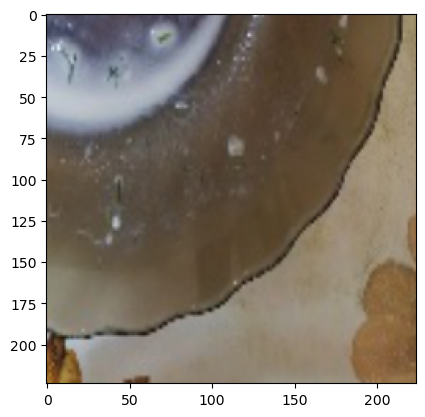

In [7]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

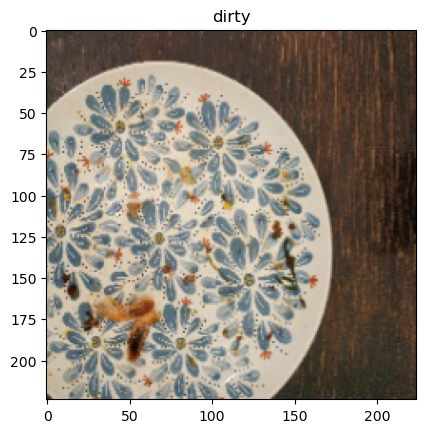

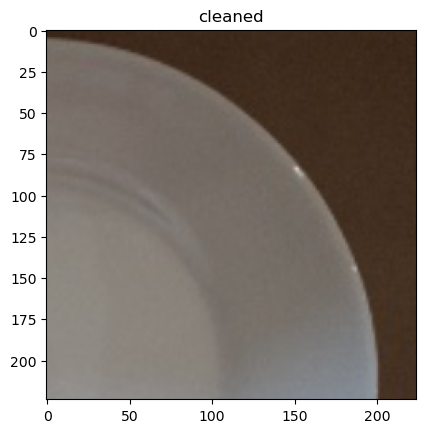

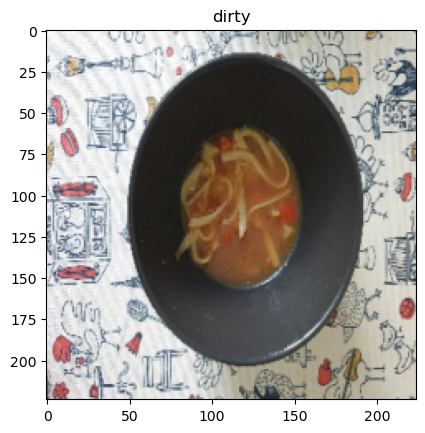

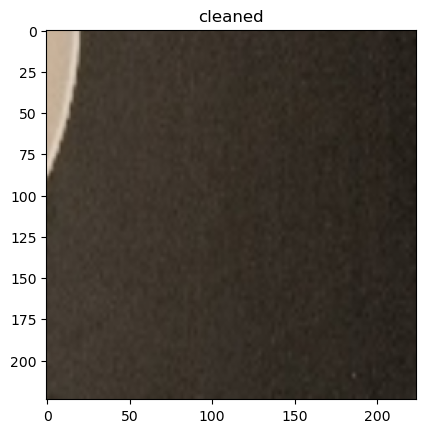

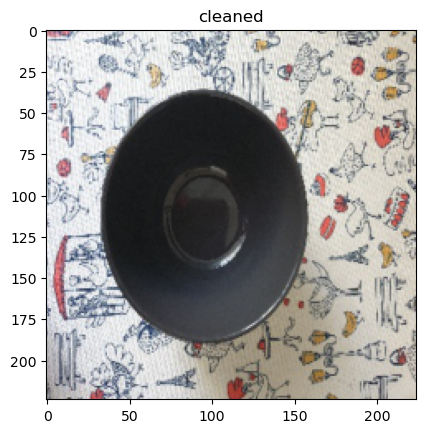

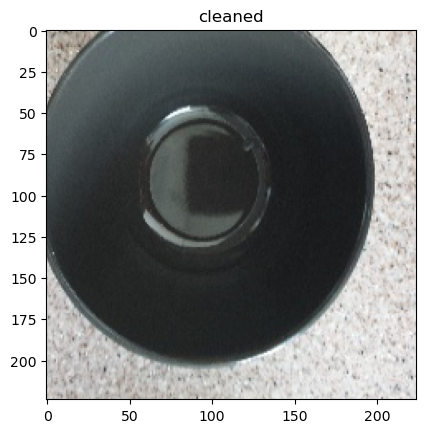

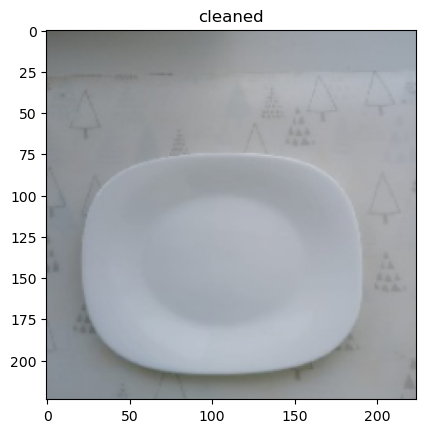

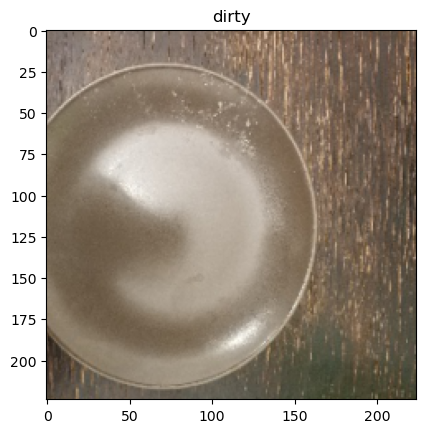

In [8]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.
            print('before iterate over data')
            print('dataloader:', dataloader)
            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                print('iterate over data started')
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [10]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:05<00:00, 9.33MB/s]


In [11]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


c:\Users\User\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


  0%|          | 0/5 [00:00<?, ?it/s]

iterate over data started


100%|██████████| 5/5 [00:06<00:00,  1.01it/s]

iterate over data started
iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

train Loss: 0.6730 Acc: 0.6000


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:05<00:00,  5.91s/it]

iterate over data started


100%|██████████| 1/1 [00:06<00:00,  6.87s/it]

val Loss: 0.7338 Acc: 0.5000
Epoch 1/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:05<00:23,  5.86s/it]

iterate over data started
iterate over data started
iterate over data started


 60%|██████    | 3/5 [00:06<00:03,  1.58s/it]

iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.43s/it]

train Loss: 0.6357 Acc: 0.6500


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:05<00:00,  5.93s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.03s/it]

val Loss: 0.6079 Acc: 1.0000
Epoch 2/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 60%|██████    | 3/5 [00:06<00:03,  1.58s/it]

iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:06<00:00,  1.25it/s]

iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.46s/it]

train Loss: 0.5767 Acc: 0.6750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.16s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.13s/it]

val Loss: 0.6324 Acc: 0.5000
Epoch 3/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 60%|██████    | 3/5 [00:06<00:03,  1.60s/it]

iterate over data started
iterate over data started
iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.47s/it]

train Loss: 0.5033 Acc: 0.7750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.26s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.26s/it]

val Loss: 0.5987 Acc: 0.8333
Epoch 4/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:06<00:24,  6.01s/it]

iterate over data started
iterate over data started


 80%|████████  | 4/5 [00:06<00:01,  1.01s/it]

iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]

train Loss: 0.4903 Acc: 0.8750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.36s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.33s/it]

val Loss: 0.6200 Acc: 0.5000
Epoch 5/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:06<00:24,  6.07s/it]

iterate over data started
iterate over data started


 60%|██████    | 3/5 [00:06<00:03,  1.66s/it]

iterate over data started
iterate over data started


 80%|████████  | 4/5 [00:06<00:01,  1.14s/it]

iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

train Loss: 0.6427 Acc: 0.5000


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.39s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.38s/it]

val Loss: 0.6062 Acc: 0.6667
Epoch 6/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:06<00:24,  6.01s/it]

iterate over data started
iterate over data started


100%|██████████| 5/5 [00:06<00:00,  1.19it/s]

iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.50s/it]

train Loss: 0.4668 Acc: 0.8750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.47s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.46s/it]

val Loss: 0.5612 Acc: 0.6667
Epoch 7/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 60%|██████    | 3/5 [00:06<00:03,  1.64s/it]

iterate over data started
iterate over data started
iterate over data started


 80%|████████  | 4/5 [00:06<00:01,  1.16s/it]

iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]

train Loss: 0.4739 Acc: 0.8250


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.44s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.44s/it]

val Loss: 0.5388 Acc: 0.8333
Epoch 8/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:06<00:24,  6.04s/it]

iterate over data started
iterate over data started


100%|██████████| 5/5 [00:06<00:00,  1.18it/s]

iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]

train Loss: 0.4623 Acc: 0.8750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.18s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.31s/it]

val Loss: 0.5475 Acc: 0.8333
Epoch 9/9:


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BBA28D0>


 20%|██        | 1/5 [00:05<00:23,  5.88s/it]

iterate over data started


 40%|████      | 2/5 [00:06<00:07,  2.55s/it]

iterate over data started


 80%|████████  | 4/5 [00:06<00:00,  1.01it/s]

iterate over data started
iterate over data started
iterate over data started


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

train Loss: 0.5599 Acc: 0.5750


before iterate over data
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x0000023C8BD5FDD0>


100%|██████████| 1/1 [00:06<00:00,  6.52s/it]

iterate over data started


100%|██████████| 1/1 [00:07<00:00,  7.51s/it]

val Loss: 0.5281 Acc: 0.8333


In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test\\unknown'

In [26]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('./test/', val_transforms)
# test_dataset = torchvision.datasets.ImageFolder('./kaggle/working/plates/test/', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [27]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: ./test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [28]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:02<00:00, 32.54it/s]


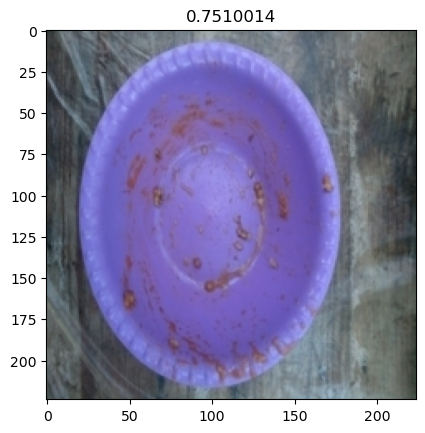

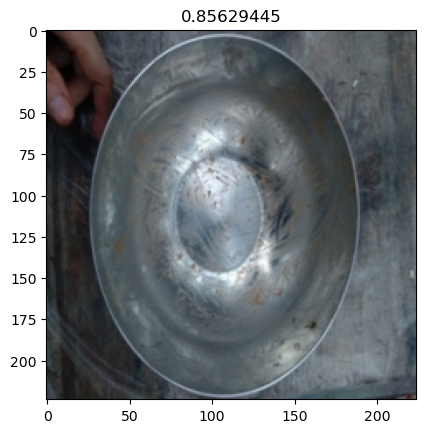

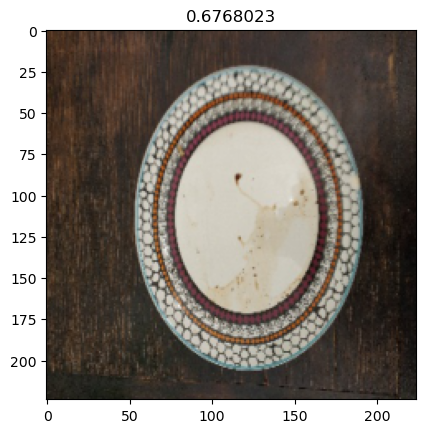

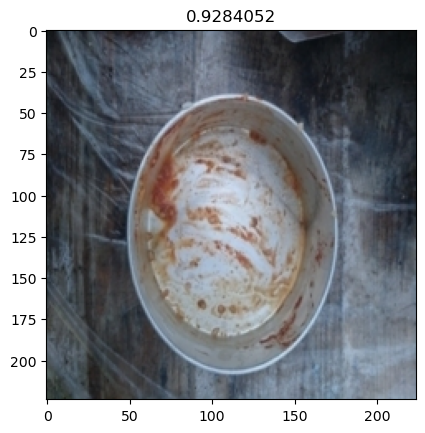

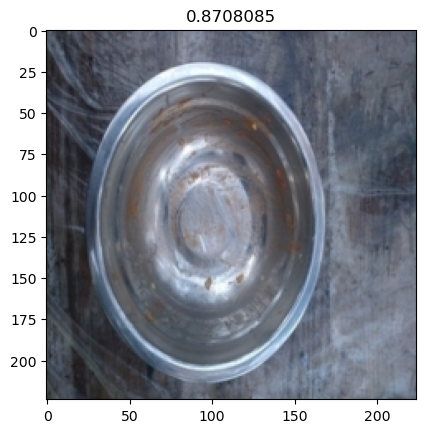

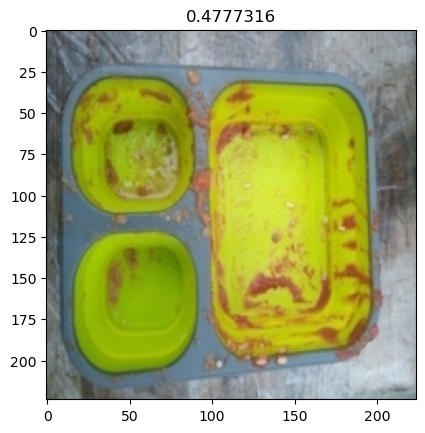

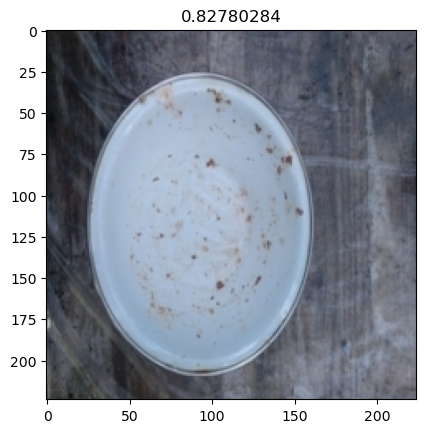

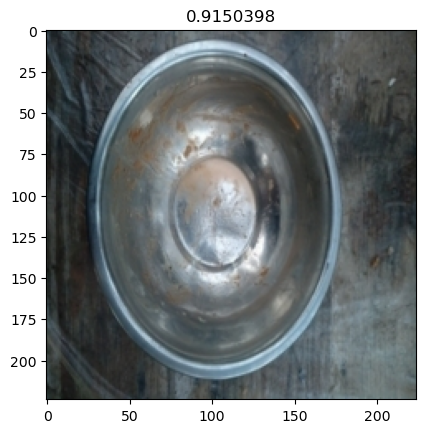

In [35]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [36]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [37]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

label
id                          
./test/unknown\0000    dirty
./test/unknown\0001    dirty
./test/unknown\0002    dirty
./test/unknown\0003    dirty
./test/unknown\0004    dirty
./test/unknown\0005  cleaned

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test